In [6]:
from math import sin, cos, log, ceil
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [77]:
# données
G=6.67408*10**(-11)
rmin=362600000          # m
e=0.0549006
mT=5.972*10**(24)       # kg
mL=7.348*10**(22)       # kg
Vpér=1083.4             # m/s

# conditions initiales
vx0=0
vy0=Vpér
x0=-rmin
y0=0

# méthode numérique
dt=1                    # seconde

In [78]:
def f(u):
    
    vx = u[0]
    vy = u[1]
    x = u[2]
    y = u[3]
    return numpy.array([-G*mT*x/((x**2+y**2)**(3/2)),
                      -G*mT*y/((x**2+y**2)**(3/2)),
                      vx,
                      vy])

In [79]:
def rk4_step(u, f, dt):
    
    k1=f(u)
    k2=f(u+0.5*dt*k1)
    k3=f(u+0.5*dt*k2)
    k4=f(u+dt*k3)

    return u + (dt/6)*(k1+2*k2+2*k3+k4)     # correspond à un pas dt dans le temps

In [80]:
T  = 2160000                        # 25 jours
dt = 1
N  = int(T/dt) + 1

# on prépare le tableau de solutions
u_rk4 = numpy.empty((N, 4))

# initialisation
u_rk4[0] = numpy.array([vx0,vy0,x0,y0])

for n in range(N-1):
    
    u_rk4[n+1] = rk4_step(u_rk4[n], f, dt)

In [81]:
vx_rk4 = u_rk4[:,0]
vy_rk4 = u_rk4[:,1]
x_rk4 = u_rk4[:,2]
y_rk4 = u_rk4[:,3]

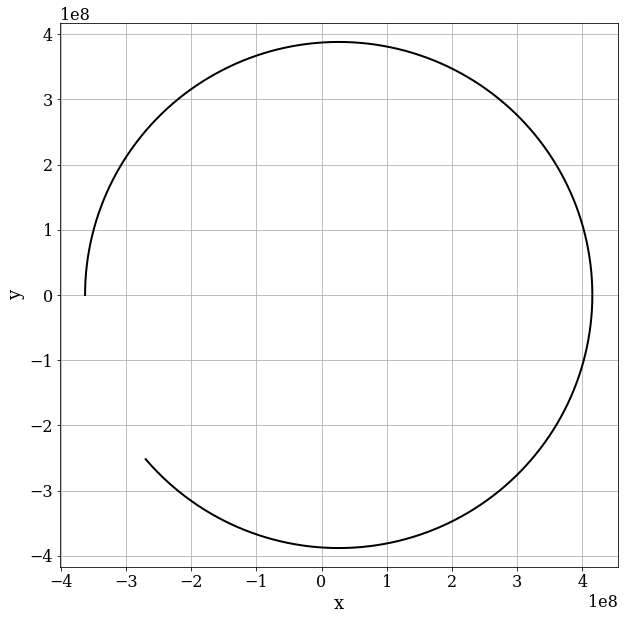

In [82]:
pyplot.figure(figsize=(10,10))
pyplot.grid(True)
pyplot.xlabel(r'x', fontsize=18)
pyplot.ylabel(r'y', fontsize=18)
pyplot.axis('equal')
pyplot.plot(x_rk4,y_rk4, 'k-', lw=2);

**Axes:**

In [83]:
idx_vx_positif = numpy.where(vx_rk4>0)[0]
print(idx_vx_positif)

[      1       2       3 ..., 1207199 1207200 1207201]


In [84]:
idx_vy_positif = numpy.where(vy_rk4>0)[0]
idx_y_positif = numpy.where(y_rk4>0)[0]
haut_extreme = numpy.intersect1d(idx_vy_positif,idx_y_positif)

print(haut_extreme)

[     1      2      3 ..., 577541 577542 577543]


In [85]:
idx_vy_negatif = numpy.where(vy_rk4<0)[0]
idx_y_negatif = numpy.where(y_rk4<0)[0]
bas_extreme = numpy.intersect1d(idx_vy_negatif,idx_y_negatif)

print(bas_extreme)

[1207202 1207203 1207204 ..., 1836857 1836858 1836859]


In [86]:
A=idx_vx_positif[-1]
print(A)
print(vy_rk4[1207201])

1207201
-945.79868311


In [87]:
B1=haut_extreme[-1]
print(B1)

577543


In [88]:
B2=bas_extreme[-1]
print(B2)

1836859


In [89]:
DEMI_AXE=(x_rk4[A]-x_rk4[0])/2
demi_axe=(y_rk4[B1]-y_rk4[B2])/2
print(DEMI_AXE)
print(demi_axe)

388976774.675
388081430.88


**Excentricité:**

In [15]:
enum=(1-(demi_axe/DEMI_AXE)**2)**(1/2)
print(enum)

0.0678106673586


**Période de l'orbite:**

(On recalcule la trajectoire en faisant en sorte que le quart de cercle soit couvert)

In [10]:
T  = 3000000                    
dt = 1
N  = int(T/dt) + 1                 

u_rk4 = numpy.empty((N, 4))

# initialisation
u_rk4[0] = numpy.array([vx0,vy0,x0,y0])

for n in range(N-1):
    
    u_rk4[n+1] = rk4_step(u_rk4[n], f, dt)

In [12]:
vx_rk4 = u_rk4[:,0]
vy_rk4 = u_rk4[:,1]
x_rk4 = u_rk4[:,2]
y_rk4 = u_rk4[:,3]

idx_y_negatif = numpy.where(y_rk4<0)[0]
idx_vy_positif = numpy.where(vy_rk4>0)[0]
idx_quart_4 = numpy.intersect1d(idx_vy_positif,idx_y_negatif)
print(idx_quart_4)

[1836860 1836861 1836862 ..., 2414401 2414402 2414403]


In [20]:
dernier_indice=idx_quart_4[-1]
periode_secondes=dernier_indice
print(periode_secondes)
periode_jours=periode_secondes/84600
print(periode_jours)

2414403
28.5390425532


**Ordre de RK4:**

Nous allons maintenant tenter de vérifier si la méthode RK4 utilisée se comporte bien de la façon attendue, c'est-à-dire si on observe bien un ordre de convergence proche de 4 pour cette méthode.
Dans un premier temps, nous allons vérifier cela de façon graphique.

On commence par chercher plusieurs trajectoires avec différents pas de temps:

In [248]:
dt_values = numpy.array([10000, 5000, 2000, 1000, 500])

u_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i, dT in enumerate(dt_values):
    
    N = int(periode_secondes/dT)+1
    
    t = numpy.linspace(0.0, periode_secondes, N)
    
    u = numpy.empty((N, 4))
    u[0] = numpy.array([vx0,vy0,x0,y0])

    for n in range(N-1):
        u[n+1] = rk4_step(u[n], f, dT)
    
    u_values[i] = u

On définit la fonction get_diffgrid qui va servir à obtenir la différence entre 2 solutions numériques et qui en prendra ensuite la norme $L_1$ de cette différence (de tableaux).

In [249]:
def get_diffgrid(u_current, u_fine, dT):
    
    N_current = len(u_current[:,0])
    N_fine = len(u_fine[:,0])
   
    grid_size_ratio = ceil(N_fine/N_current)
    
    diffgrid = dT * numpy.sum( numpy.abs(\
            u_current[:,2]- u_fine[::grid_size_ratio,2])) 
    
    return diffgrid

On cherche alors la norme $L_1$de la différence entre chaque solution numérique et celle qui possède le plus petit pas (ici, 500 secondes).

In [250]:
diffgrid = numpy.empty_like(dt_values)
for i, dT in enumerate(dt_values):

    diffgrid[i] = get_diffgrid(u_values[i], u_values[-1], dT)

print(diffgrid)

[21363758  1304794    32825     1931        0]


On porte ces valeurs en graphique en fonction du pas de temps:

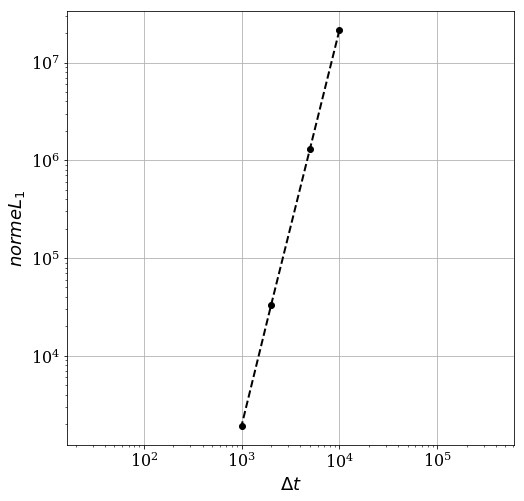

In [253]:
pyplot.figure(figsize=(8,8))
pyplot.grid(True)
pyplot.xlabel(r'$\Delta t$', fontsize=18)
pyplot.ylabel(r'$norme L_1$', fontsize=18)
pyplot.axis('equal')
pyplot.loglog(dt_values[:-1], diffgrid[:-1], color='k', ls='--', lw=2, marker='o');

Globalement, on semble obtenir un bon résultat: les normes des différences entre chaque solution et celle de plus petit pas diminuent rapidement avec le pas de temps. De plus, on peut observer graphiquement que la pente de la droite obtenue est environ 4.

Pour étudier plus précisément la convergence de notre méthode, on peut calculer l'ordre de convergence p observé. Pour ce faire, on utilise 3 solutions numériques dont les pas diffèrent à un rapport r constant et on utilise la formule:

$$ p=\frac{\log{\frac{f_3-f_2}{f_2-f_1}}}{\log{r}} $$

( $f_1$ et $f_3$ correspondant à la solution de plus petit pas et de plus grand pas respectivement)

In [255]:
r = 2
h = 3600

dt_values = numpy.array([h, r*h, r**2*h])

u_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

diffgrid = numpy.empty(2) 

for i, dT in enumerate(dt_values):
    
    N = int(periode_secondes/dT) + 1 


    u = numpy.empty((N, 4))
    u[0] = numpy.array([vx0,vy0,x0,y0])

    for n in range(N-1):

        u[n+1] = rk4_step(u[n], f, dT)
    
    u_values[i] = u
    

### f2 - f1
diffgrid[0] = get_diffgrid(u_values[1], u_values[0], dt_values[1])

### f3 - f2
diffgrid[1] = get_diffgrid(u_values[2], u_values[1], dt_values[2])

### ordre de cvgce
p = (log(diffgrid[1])-log(diffgrid[0])) / log(r)

print('Ordre de convergence: p = {:.3f}'.format(p));

Ordre de convergence: p = 4.048


*Remarque:* on a choisi des valeurs de h beaucoup plus élevées qu'une seconde parce que les valeurs de pas très petites par rapport à l'échelle de temps du problème (1, 2 et 4 secondes par exemple) ne sont pas adaptées pour un calcul d'ordre de convergence.

**Question 5, snif...**

In [239]:
def f(u):
    vx = u[0]
    vy = u[1]
    x = u[2]
    y = u[3]
    return numpy.array([-G*mT*x/((x**2+y**2)**(3/2)),
                      -G*mT*y/((x**2+y**2)**(3/2)),
                      vx,
                      vy])

In [240]:
def rk4_step(u, f, dt):
    
    k1=f(u)
    k2=f(u+0.5*dt*k1)
    k3=f(u+0.5*dt*k2)
    k4=f(u+dt*k3)

    return u + (dt/6)*(k1+2*k2+2*k3+k4)     # correspond à un pas dt dans le temps

In [241]:
# données
G=6.67408*10**(-11)
rmin=362600000          # m
e=0.0549006
mT=5.972*10**(24)       # kg
mL=7.348*10**(22)       # kg
Vpér=1083.4             # m/s
rmax=2*DEMI_AXE-rmin

# conditions initiales
Lvx0=0
Lvy0=-945.8
Lx0=rmax
Ly0=0

Avx0=-500
Avy0=500
Ax0=26380112
Ay0=0


In [242]:
def fbis(uA,uCM):
    
    CMvx = uCM[0]
    CMvy = uCM[1]
    CMx = uCM[2]
    CMy = uCM[3]
    
    Avx = uA[0]
    Avy = uA[1]
    Ax = uA[2]
    Ay = uA[3]
    
    return numpy.array([G*(mT+mL)*(CMx-Ax)/(((CMx-Ax)**2+(CMy-Ay)**2)**(3/2)),
                      G*(mT+mL)*(CMy-Ay)/(((CMx-Ax)**2+(CMy-Ay)**2)**(3/2)),
                      Avx,
                      Avy])

In [243]:
def rk4_step_bis(uA, uCM, fbis, dt):
    
    k1=fbis(uA,uCM)
    k2=fbis(uA+0.5*dt*k1,uCM+0.5*dt*k1)
    k3=fbis(uA+0.5*dt*k2,uCM+0.5*dt*k2)
    k4=fbis(uA+dt*k3,uCM+dt*k3)

    return uA + (dt/6)*(k1+2*k2+2*k3+k4)

In [244]:
T  = 1209600                       # 14 jours
dT = 100
N  = int(T/dT) + 1

# on prépare le tableau de solutions

A_u_rk4 = numpy.empty((N, 4))
L_u_rk4 = numpy.empty((N, 4))
CM_u_rk4= numpy.empty((N, 4))

# initialisation
A_u_rk4[0] = numpy.array([Avx0,Avy0,Ax0,Ay0])
L_u_rk4[0] = numpy.array([Lvx0,Lvy0,Lx0,Ly0])
CM_u_rk4[0] = (mL/(mL+mT))*L_u_rk4[0]

for n in range(N-1):
    
    L_u_rk4[n+1] = rk4_step(L_u_rk4[n], f, dT)
    CM_u_rk4[n+1] = (mL/(mL+mT))*L_u_rk4[n+1]
    A_u_rk4[n+1] = rk4_step_bis(A_u_rk4[n], CM_u_rk4[n], fbis, dT)  

In [245]:
Ax = A_u_rk4[:,2]
Ay = A_u_rk4[:,3]
CMx = CM_u_rk4[:,2]
CMy = CM_u_rk4[:,3]

**Animations**

In [256]:
from matplotlib import animation
from IPython.display import HTML

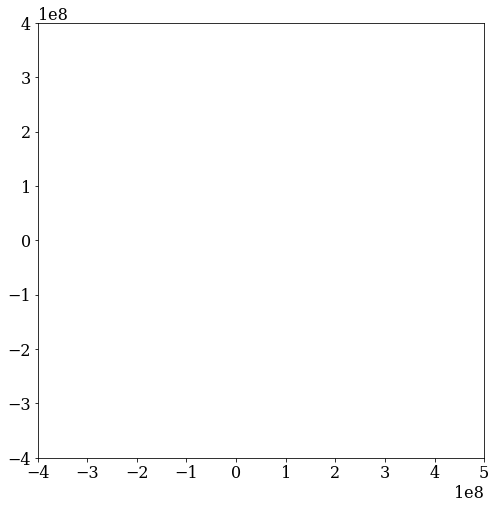

In [258]:
fig = pyplot.figure(figsize=(8,8))
ax = pyplot.axes(xlim=(-4*10**8,5*10**8), ylim=(-4*10**8,4*10**8))
line = ax.plot([], [], color='#003366', ls='--', lw=3)[0]

In [261]:
vx0=0
vy0=Vpér
x0=-rmin
y0=0

T  = periode_secondes
dt = 100
N  = int(T/dt) + 1


u_rk4 = numpy.empty((N, 4))

u_rk4[0] = numpy.array([vx0,vy0,x0,y0])

for n in range(N-1):
    
    u_rk4[n+1] = rk4_step(u_rk4[n], f, dt)

vx_rk4 = u_rk4[:,0]
vy_rk4 = u_rk4[:,1]
x_rk4 = u_rk4[:,2]
y_rk4 = u_rk4[:,3]

In [262]:
def orbite(i):
    line.set_data(x_rk4,y_rk4)

    u_rk4[n+1] = rk4_step(u_rk4[n], f, dt)
    x_rk4 = u_rk4[:,2]
    y_rk4 = u_rk4[:,3]

In [263]:
anim = animation.FuncAnimation(fig, diffusion,
                               frames=nt, interval=100)

NameError: name 'diffusion' is not defined

In [264]:
HTML(anim.to_html5_video())

NameError: name 'anim' is not defined